[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaralAminpour/ML-BME-Course-UofA-Fall-2023/blob/main/Week-5-Clustering%20and%20Features/5.3-Feature-selection.ipynb)

#Part III: Feature selection

In this notebook we will look again at the brain structure volumes of preterm babies. We will see how feature selection can prevent overfitting, improve performance of models and how it can also help in feature interpretation.

In [ ]:
###################################
## RUN THIS
###################################
# This code is to suppress warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
####################################

In [ ]:
# This code will download the required data files from GitHub
import requests
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'SirTurtle'
    repo = 'ML-BME-UofA-data'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Week-6-Feature-extraction-and-selection/data/GA-structure-volumes-preterm.csv', 'temp/GA-structure-volumes-preterm.csv')
download_data('Week-6-Feature-extraction-and-selection/data/labels', 'temp/labels')

## Brain structure volumes

We will load again the dataset of 86 brain structure volumes of 164 preterm babies. We will revisit prediction of GA from the volumes. Recall, that Multivariate Linear Regression resulted in overfitting of the data and Lasso and Ridge penalties were successful in reducing the overfitting.

### Load data

The code below loads the data, creates the feature matrix and the target vector and performs the feature scaling.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Read spreadsheet using pandas
data = pd.read_csv("temp/GA-structure-volumes-preterm.csv", header=None)

# Convert from 'DataFrame' to numpy array
structure_volumes = data.to_numpy()

# Features
X = structure_volumes[:,1:]

# Targets
y = structure_volumes[:,0]

# Checking the size of the feature and target arrays
# Note they must agree in the first dimension
print('Features shape: {}; Targets shape: {}'.format(X.shape,y.shape))
# We have 86 features and 164 samples

# Scale features
X = StandardScaler().fit_transform(X)
print('Performed feature scaling.')

Features shape: (164, 86); Targets shape: (164,)
Performed feature scaling.


We are interested in finding out which features are selected by our models as most predictive of the age at scan. The code below reads the structure names and stores them as a `dataframe` object `structure_names`.

In [ ]:
# Read file with structure names
structure_names = pd.read_csv('temp/labels', header=None, sep='\t')
structure_names[1]

0                                Hippocampus left
1                               Hippocampus right
2                                   Amygdala left
3                                  Amygdala right
4     Anterior temporal lobe, medial part left GM
                         ...                     
81                          Parietal lobe left WM
82                                            CSF
83                       Intra-cranial background
84       Thalamus right, low intensity part in T2
85        Thalamus left, low intensity part in T2
Name: 1, Length: 86, dtype: object

### Multivariate linear regression

Multivariate linear regression overfitted the data. Rembember the performance of linear regression to see whether feature selection can help us improve it.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error')
print(f'Linear regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

Linear regression: Cross-validated RMSE is 2.08 weeks.


### Ridge

Previously, we have found that optimal `alpha` for Ridge regression was around 45. This setting significanlty reduced overfitting. Let's rerun this model. Remember the performance of Ridge regression as a baseline for good performance.

In [ ]:
from sklearn.linear_model import Ridge

model = Ridge(alpha = 45)
scores = cross_val_score(model, X, y, scoring = 'neg_mean_squared_error')
print(f'Ridge regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

Ridge regression: Cross-validated RMSE is 1.17 weeks.


We will now explore different feature selection techniques in Scikit-learn.


## Univariate feature selection

### Pearson's correlation coefficient

Correlation coefficient can be calculated using function `pearsonr` from `scipy.stats` module. High correlation (positive and negative) means close to linear relationship with target values. Note that most, but not all, volumes are highly correlated with GA.

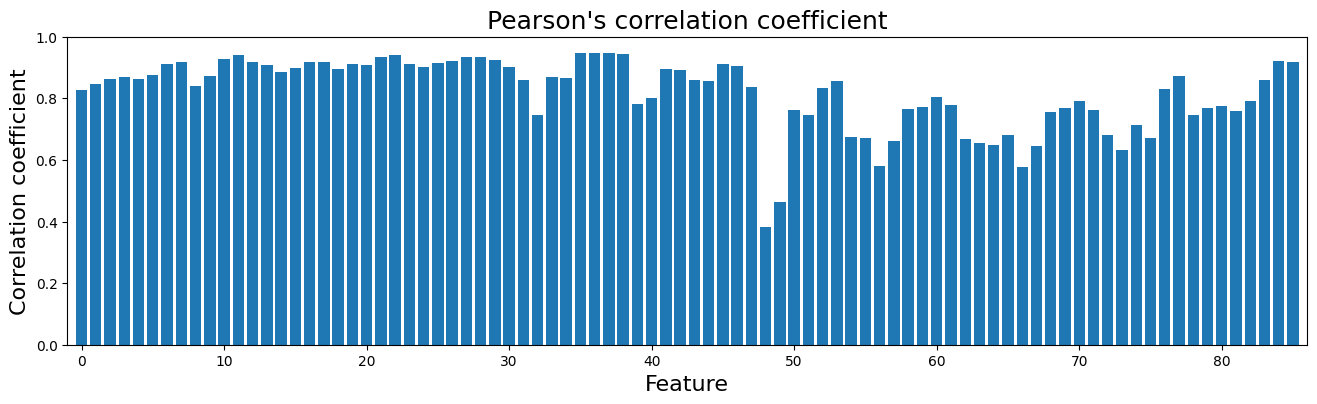

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import pearsonr

n = X.shape[1]
cc = np.zeros(n)
for i in range(n):
    cc[i] = pearsonr(X[:,i],y)[0]

plt.figure(figsize = [16,4])
plt.bar(np.arange(n),cc)
plt.title("Pearson's correlation coefficient", fontsize = 18)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('Correlation coefficient', fontsize = 16)
plt.axis([-1,86,0,1])
plt.show()

### F-score

Scikit-learn works with F-values rather than Pearson's Correlation Coefficient. However, these two are equivalent for feature selection.

The F-value can be calculated using `f_regression` in `sklearn`.
[f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html)

**Activity 1.1:** Complete the code below to plot F-scores using a `bar` plot.

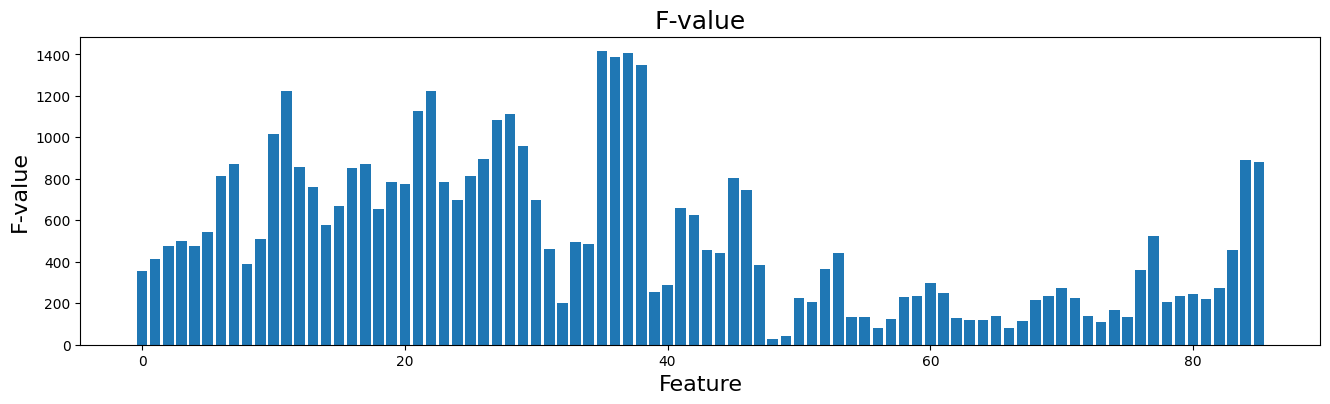

In [ ]:
from sklearn.feature_selection import f_regression

f_score = f_regression(None,None)[0]

# Plot f-scores
plt.figure(figsize = [16,4])
plt.bar(np.arange(n), None)  # Remember n = X.shape[1]
plt.title('F-value', fontsize = 18)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('F-value', fontsize = 16)
plt.show()

**Activity 1.2:** Plot relationship between Pearson's correlation coefficient and F-score using `plot`. Are they equivalent?

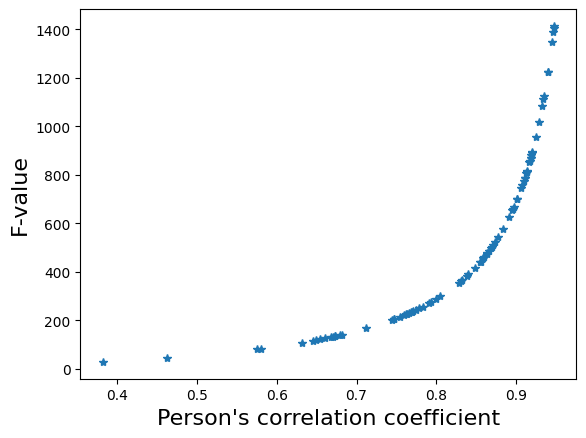

In [ ]:
# Plot relationship
plt.plot(None, None,'*')  # Remember the variable 'cc' stores Pearson's correlation coefficient
plt.xlabel("Person's correlation coefficient", fontsize = 16)
plt.ylabel('F-value', fontsize = 16)
plt.show()

### Selecting features based on F-value
<img src="pictures/brain.png" width = "250" style="float: right;">

We can select the top scoring features to improve the performance of the method. Scikit-learn offers two built-in functions to do that: `SelectKBest` and `SelectPercentile`. Let's start by selecting 4 best features using `SelectKBest`.

Run the code below to transform the feature matrix `X` into the matrix of selected features `X_selected`.

**Activity 1.3:** Check:
* The size of the new matrix - is it what you expect?
* The indices of the features that have been selected;
* The names of the selected features.

In [ ]:
from sklearn.feature_selection import SelectKBest

# Define feature selection model
k = 4
selector = SelectKBest(f_regression, k = k)

# Select features
X_selected = selector.fit_transform(X,y)

# Shape of the matrix
print('Shape of the new matrix: ', None)

# Indices of the selected features
ind = np.where(selector.get_support())[0]
print('Indices: ', ind)

# Print the names of the selected structures
print('\n')
for i in range(k):
    print(structure_names.loc[None,1])

Shape of the new matrix:  (164, 4)
Indices:  [35 36 37 38]


Frontal lobe right GM
Frontal lobe left GM
Parietal lobe right GM
Parietal lobe left GM


### Univariate feature selection for improved prediction

**Activity 1.4:** Let's now apply the multivariate linear regression to the selected features and see whether performance improves.

In [ ]:
# Fit linear regression model to selected features
model = None
model.fit(X_selected,y)

# Calculate and print RMSE
scores = None  # Use scoring = 'neg_mean_squared_error'
print(f'Linear regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

Linear regression: Cross-validated RMSE is 1.39 weeks.


We see that we reduced overfitting, but we did not reach the performance of Lasso or Ridge.

**Activity 1.5:** Try to vary the number of selected features to see what works best. Remember this performance as the best for univariate feature selection.

In [ ]:
# Define feature selection model
k = None  # Modify this line
selector = SelectKBest(f_regression, k = k)

# Select features
X_selected = selector.fit_transform(X,y)

# Shape of the matrix
print('Shape of the new matrix: ', X_selected.shape)

# Indices of the selected features
ind = np.where(selector.get_support())[0]
print('Indices: ', ind)

# Print the names of the selected structures
print('\n')
for i in range(k):
    print(structure_names.loc[ind[i],1])

# Fit linear regression model to selected features
model = LinearRegression()
model.fit(X_selected,y)

# Calculate and print RMSE
scores = cross_val_score(model, X_selected, y, scoring = 'neg_mean_squared_error')
print(f'Linear regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

Shape of the new matrix:  (164, 1)
Indices:  [35]


Frontal lobe right GM
Linear regression: Cross-validated RMSE is 1.34 weeks.


## Exercise 1

Select 4 top scoring features using mutual information. Do you obtain the same or different features as for correlation coefficient?

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# Set number of features to select
k = 4

# Create feature selector
selector = None  # Use mutual_info_regression instead of f_regression

# select features
X_selected = None

# Indices of the selected features
ind = None

# Print the names of the selected structures
print('\n')
for i in range(k):
    print(structure_names.loc[ind[i],1])



Cerebellum left
Cerebellum right
Frontal lobe right GM
Frontal lobe left GM


## Model based feature selection - Lasso

We will now select the features based on `Lasso` model. We have previously found that setting `alpha=0.16` results in the best Lasso model for our example. The code below creates the model, calculates its performance and prints out the number of sparse coefficients.

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.16)
scores = cross_val_score(model, X, y, scoring = 'neg_mean_squared_error')
print(f'Lasso regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

model.fit(X,y)
print('\n Non-zero coefficients')
print(model.sparse_coef_)
print('\n There are {} non-zero coefficients.'.format(model.sparse_coef_.count_nonzero()))

Lasso regression: Cross-validated RMSE is 1.3 weeks.

 Non-zero coefficients
  (0, 11)	0.06002415751697485
  (0, 14)	0.05960219778786447
  (0, 17)	0.17243679150204805
  (0, 23)	0.5021540982764866
  (0, 25)	0.10323098749035524
  (0, 26)	0.5188666211532907
  (0, 29)	0.4185868037341181
  (0, 38)	0.693085255013357
  (0, 42)	0.15754434132199457
  (0, 55)	0.06438571415023106
  (0, 82)	0.601692289152662
  (0, 84)	0.16800728136709359
  (0, 85)	0.4134904509464669

 There are 13 non-zero coefficients.


The code below extracts the indices of non-zero Lasso coefficients and lists the names of the selected structures.

In [ ]:
# Indices of non-zero elements
ind = model.sparse_coef_.nonzero()[1]
print('Indices of non-zero elements: ', ind)
print('\n')

# Print names of selected structures
print('Selected structures: \n')
for i in range(ind.size):
    print(structure_names.loc[ind[i],1])

Indices of non-zero elements:  [11 14 17 23 25 26 29 38 42 55 82 84 85]


Selected structures: 

Superior temporal gyrus, middle part right GM
Lateral occipitotemporal gyrus, gyrus fusiformis anterior part left GM
Cerebellum right
Gyri parahippocampalis et ambiens posterior part right GM
Lateral occipitotemporal gyrus, gyrus fusiformis posterior part right GM
Lateral occipitotemporal gyrus, gyrus fusiformis posterior part left GM
Superior temporal gyrus, posterior part right GM
Parietal lobe left GM
Thalamus left, high intensity part in T2
Gyri parahippocampalis et ambiens anterior part right WM
CSF
Thalamus right, low intensity part in T2
Thalamus left, low intensity part in T2


## Exercise 2

We will now use the `LassoCV` model for feature selection and fit the selected features using `LinearRegression`.
* Implement the feature selection using selector `SelectFromModel` with `LassoCV` model;
* Calculate the performance of `LinearRegression` using the selected features;
* Experiment with different thresholds for Lasso coefficients to see which one results in the best performance.

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

# Create selector with LassoCV model
selector = SelectFromModel(None, threshold=0.3)  # Experiment with different thresholds

# Perform feature transformation
X_selected = selector.fit_transform(X, y)

# Create and fit linear regression model to selected features
model = None
model.fit(X_selected,y)

# Calculate and print RMSE
scores = None  # Use scoring = 'neg_mean_squared_error'
print(f'Linear regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

# List the number and names of the selected features
ind = selector.get_support(indices=True)
print('\nSelected {} features: '.format(ind.size),)
for i in range(ind.size):
    print(structure_names.loc[ind[i],1])

Linear regression: Cross-validated RMSE is  1.18

Selected 6 features: 
Gyri parahippocampalis et ambiens posterior part right GM
Lateral occipitotemporal gyrus, gyrus fusiformis posterior part left GM
Superior temporal gyrus, posterior part right GM
Parietal lobe left GM
CSF
Thalamus left, low intensity part in T2


We see that feature selection using LassoCV with optimised threshold results in performance of Linear regression similar to optimised Ridge. This is better that for univariate feature selection.

## Model based feature selection - Random forest

Random forest is very resilient to overfitting. Let's now fit the random forest regressor to the data and see how it performs. Note that Random forest allows for non-linear models, and it is therefore not surprising that it outperforms the Linear Regression Models.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Select and fit the model
model = RandomForestRegressor(n_estimators=20)

# Calculate CV RMSE
scores = cross_val_score(model, X, y, scoring = 'neg_mean_squared_error')
print(f'Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

Cross-validated RMSE is 1.08 weeks.


**Activity 2.1:** Feature importances can be access as `model.feature_importances_`. Plot the feature importances using a `bar` plot.

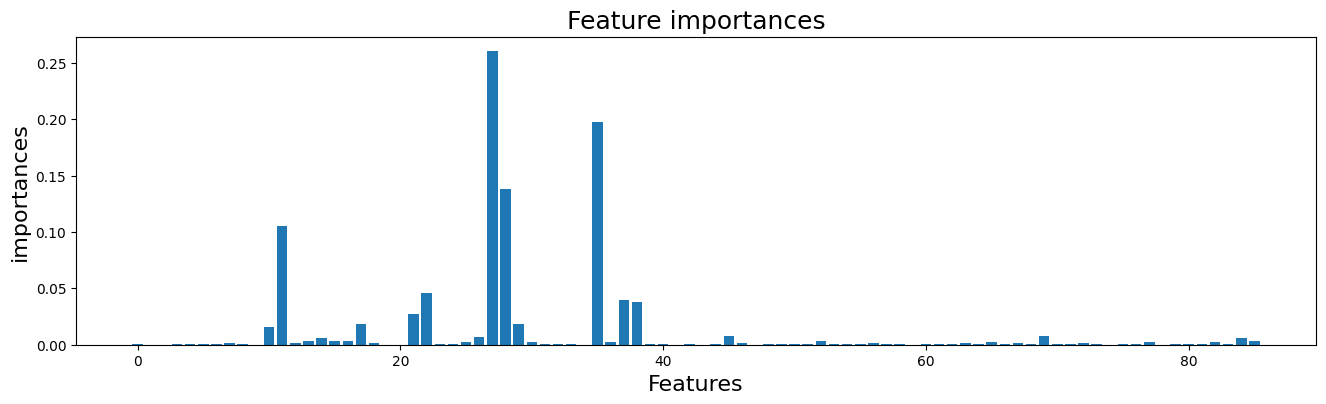

In [ ]:
# Fit the model
model.fit(X,y)

# Plot feature importances
plt.figure(figsize = [16,4])
n = X.shape[1]
plt.bar(np.arange(n), None)
plt.title('Feature importances', fontsize = 18)
plt.xlabel('Features', fontsize = 16)
plt.ylabel('importances', fontsize = 16)
plt.show()

**Activity 2.2:** Use selector `SelectFromModel` to select the features from `RandomForestRegressor(n_estimators=20)`. Choose threshold 0.05 and print the names of the selected features. Are they consistent with the ones selected by Lasso or Correlation Coefficient?

In [ ]:
# Create selector with LassoCV model
selector = None

# Perform feature transformation
X_selected = selector.fit_transform(X, y)

# List the number and names of the selected features
ind = selector.get_support(indices=True)
print('Selected {} features: '.format(ind.size),)
for i in range(ind.size):
    print(structure_names.loc[ind[i],1])

Selected 4 features: 
Medial and inferior temporal gyri posterior part right GM
Medial and inferior temporal gyri posterior part left GM
Frontal lobe right GM
Parietal lobe left GM


## Recursive feature elimination

Scikit learn offers functions `RFE` and `RFECV` to perform recursive feature elimination. Any model can be used to do that, and this time we will choose `Ridge` regression.  

Let's first find 4 best features using `RFE` with `Ridge`. Run the code below to fit `RFE` model and print the names of the selected features.

In [ ]:
from sklearn.feature_selection import RFE

k = 4

# Create ranking model
model = Ridge(alpha=45)

# Create selector
selector = RFE(model, n_features_to_select=k)

# Fit selector
selector.fit(X,y)

# Print the indices of the selected features
ind = np.where(selector.get_support())[0]
print('Indices: ', ind)

# Print the names of the selected structures
print('\n')
for i in range(k):
    print(structure_names.loc[ind[i],1])

NameError: ignored

**Activity 3.1:** Transform the features, fit linear regression and calculate CV RMSE to see whether we reduced overfitting.

In [ ]:
# Select features
X_selected = selector.transform(None)

# Linear regression
model = None
scores = None
print(f'Linear regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

Linear regression: Cross-validated RMSE is 1.18 weeks.


## Exercise 3
Let's now use method `RFECV` that can also automatically select optimal number of features using cross-validation. Write the code to:
* Fit the `RFECV` feature selection with `Ridge(alpha=45)` ranking model;
* Transform the features and fit the `Ridge(alpha = 45)` model to the selected features;
* Calculate the CV RMSE;
* Print indices of selected features;
* Print number of selected features.

In [ ]:
from sklearn.feature_selection import RFECV

# Create ranking model
model = None

# Create selector
selector = RFECV(model)

# Fit the selector and transform the features
X_selected = selector.fit_transform(None, None)

# Calculate performance of Ridge with selected features
scores = None
print(f'Linear regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

# Print indices of the selected features
ind = np.where(None)[0]
print('Indices: ', ind)

# Print number of selected features
print('Number of selected features: ', None)

Linear regression: Cross-validated RMSE is 1.1 weeks.
Indices:  [ 1  7  9 10 11 14 16 17 18 20 21 22 23 24 25 26 28 29 30 35 36 37 38 39
 40 41 42 45 46 55 56 57 60 62 63 64 66 68 69 71 75 77 78 80 81 82 84 85]
Number of selected features:  48


### Recursive feature elimination using Random Forest

**Activity 3.2:** Perform recursive feature elimination using `RFECV` and `RandomForestRegressor(n_estimators=20)`. Be patient, this process might take time.

In [ ]:
from sklearn.feature_selection import RFECV

model = None
selector = RFECV(model)
selector.fit(X,y)

# Print selected features
ind = np.where(selector.get_support())[0]
print('Indices: ', ind)

print('Number of selected features: ', None)

Indices:  [ 5  6  7 10 11 14 15 16 17 18 21 22 24 25 26 27 28 29 30 31 32 35 37 38
 52 54 55 56 57 60 63 64 65 67 69 70 72 77 82 84 85]
Number of selected features:  41


**Activity 3.3:** Transform the features and fit the `RandomForestRegressor(n_estimators=20)` to see whether CV RMSE improved.

In [ ]:
# Select features
X_selected = selector.transform(X)

# Linear regression
model = None
scores = None
print(f'Linear regression: Cross-validated RMSE is {round(np.sqrt(-scores.mean()),2)} weeks.')

Linear regression: Cross-validated RMSE is 1.08 weeks.


# Conclusion

We have seen that feature selection can prevent overfitting and improve performance of the model. We have also seen that Random forest is very resilient against overfitting and does not particularly benefit from feature selection. On the contrary, it is a very good tool for selecting features for other methods.

We have also seen that selected features varied a lot dependent on the selection method. We therefore need to be careful when interpreting the selected features.